For deep learning training, you need to first **change the Colab runtime** to `T4 GPU` in the upper right corner.

![Change Colab Runtime to T4 GPU](/images/Change_Colab_Runtime.png "Change Colab Runtime to T4 GPU")

Upload `thumbnail_ctr.csv` to Colab by drag and drop into the left *Files* section.

In [5]:
import pandas as pd

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('thumbnail_ctr.csv')

# Delete NaN rows
df = df.dropna()
# Reindex the DataFrame
df = df.reset_index(drop=True)
df.head()

,Video title,thumbnail,Impressions click-through rate (%)
0,When you want to crochet and you have a baby,https://i.ytimg.com/vi/9ePFI7814Rc/default.jpg,1.26
1,Crochet Leaves,https://i.ytimg.com/vi/jx2ojGTX854/default.jpg,4.57
2,How to crochet pet collar | crochet tulips | B...,https://i.ytimg.com/vi/M5pbgRzZs6w/default.jpg,4.39
3,How to wrap flowers | crochet flower bouquet,https://i.ytimg.com/vi/rBFqpv-m6gc/default.jpg,4.69
4,Crochet for beginners: How to crochet scrunchi...,https://i.ytimg.com/vi/2hPsxSXwsf8/default.jpg,3.11


Blow is a code example of using fast.ai library to download and show images from url.

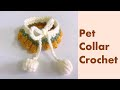

In [7]:
from fastdownload import download_url
dest = 'thumbnail.jpg'
download_url(df['thumbnail'][2], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [9]:
average_value = df['Impressions click-through rate (%)'].mean()
average_value

2.716734693877551

Seperate datasest into two caterogies: **below average** and **above average**.

In [11]:
below_average_df = df[df['Impressions click-through rate (%)'] < average_value]
above_average_df = df[df['Impressions click-through rate (%)'] >= average_value]

Dowload images from two categories into two different folders named **above_average** and **below_average**. Fast.ai library will use folder's name to lable the images for training.

In [14]:
searches = 'below_average','above_average'
path = Path('thumbnail_cover_image')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    if o == 'below average':
      o_df = below_average_df
    else:
      o_df = above_average_df

    download_images(dest, urls=o_df['thumbnail'])
    resize_images(path/o, max_size=400, dest=path/o)

In [20]:
#Delete unvalid image links
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

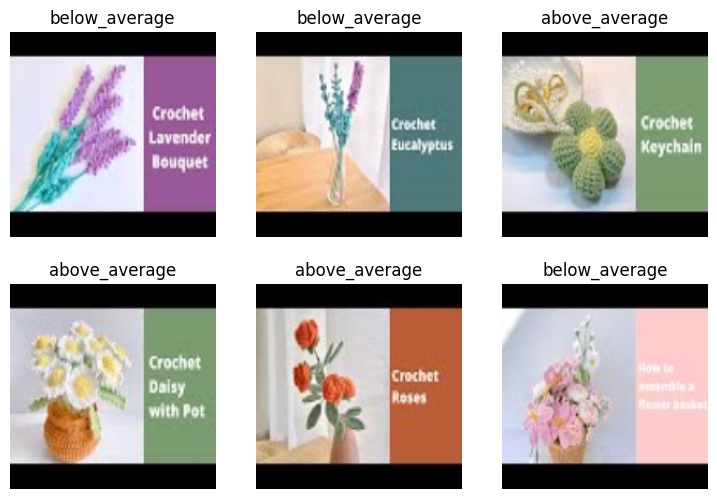

In [21]:
#Build fast.ai datablock for next step
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

**Fine tune** the existing **Resnet** model which has been pre-trained on millions of images. **Fine tune** method only train the last layer of the pre-trained model for the user's dataset. Therefore, it saves time.

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.438015,1.381293,0.500000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.690220,1.451846,0.500000,00:01
1,1.592969,1.636217,0.500000,00:00
2,1.496134,1.836272,0.600000,00:00


Upload an example.jpg to text model

In [23]:
is_above_average,_,probs = learn.predict(PILImage.create('example.jpg'))
print(f"This is a: {is_above_average}.")
print(f"Probability its click-through rate above average: {probs[0]:.4f}")

This is a: above_average.
Probability its click-through rate above average: 0.8472


Export the fine-tuned model and download from the **Files** section of colab for next step.

In [25]:
learn.export('model.pkl')

Download and upload this notebook to Colab. Convert it to markdown using nbconvert for blogging reason.

In [ ]:
!jupyter nbconvert --to markdown Train_Model.ipynb